# Experiment 3:
## Behaviour of BIHT/BIP on MNIST for various sparsity levels and bottlenecks.


This experiment shows the behaviour of the Binary Iterative Hard Thresholding/Projection method for various sparsity levels and bottleneck sizes of the following structural assumptions:
- Sparsity in standard basis,
- Sparsity in single level 2D Haar wavelets and
- Generative model.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;

import pywt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

from torch.utils.data import DataLoader;
import torchvision;

import pickle;
import time;
import random;
import math;

from IPython.display import clear_output;

import MNIST_utils as MNIST;
import MNIST_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization 

In [2]:
(train_data, test_data), (train_loader, test_loader) = MNIST.load_dataset();
m_min = 1;
m_max = 10000;
sspace = [10, 50, 100, 150, 200];
kspace = [10, 50, 100, 150, 200];

noise = 0.1;

In [3]:
def plot_data(data):
    x_data = [];
    y_data = [];
    z_data = [];
    for subdata in data:
        x_subdata = [];
        y_subdata = [];
        z_subdata = [];
        for (s, best, worst, threshold_m) in subdata:
            x_subdata.append(best);
            y_subdata.append(threshold_m);
            z_subdata.append(s);
        x_data.append(x_subdata);
        y_data.append(y_subdata);
        z_data.append(z_subdata);
    
    for i in range(len(data)):
        plt.plot(x_data[i], y_data[i], linewidth = 3);        
        plt.scatter(x_data[i], y_data[i]);
        plt.xlabel("Best approximation");
        plt.ylabel("Threshold m");
    plt.show();
    
    for i in range(len(data)):
        plt.plot(z_data[i], y_data[i], linewidth = 3);
        plt.scatter(z_data[i], y_data[i]);
        plt.xlabel("sparsity");
        plt.ylabel("Threshold m");
    plt.show();

# Standard basis experiment

latest s: 200


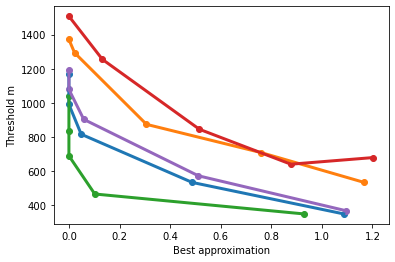

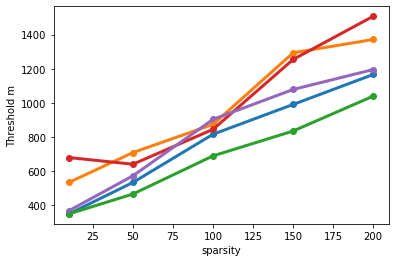

In [8]:
def experiment(x, s, m, repetitions = 3):
    accum = 0;
    for j in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        _, accuracy = MNIST.reconstruct_BIP(A, q, x, lambda x : sparsity.HT(x, s), learning_param = 0.001, iterations = 500);
        accum = accum + accuracy;
    return accum/repetitions;

def bisection(x, s, eps = 10):
    best = sparsity.best_normalized_error(x, s);
    worst = experiment(x, s, 1);
    threshold = 0.5*(best + worst);
    
    _m_h = m_max;
    _m_l = m_min;
    
    while (_m_h - _m_l > eps):
        _m_m = int(0.5*(_m_h + _m_l));
        _m_m_value =  experiment(x, s, _m_m);
        if _m_m_value < threshold:
            _m_h = _m_m;
        else:
            _m_l = _m_m;
    
    return 0.5*(_m_h + _m_l);
    
data_sparsity = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    data_sparsity.append([]);
    for s in sspace:
        best = sparsity.best_normalized_error(x, s);
        worst = experiment(x, s, 1);
        threshold_m = bisection(x, s);
        tup = (s, best, worst, threshold_m);
        data_sparsity[j].append(tup);

        clear_output(wait=True);
        print("latest s: " + str(s));
        plot_data(data_sparsity);

In [9]:
utils.saveData(data_sparsity, "results_data/mnist_standard_basis_complexity.dat");

# Haar

latest s: 200


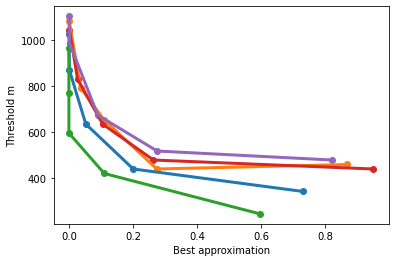

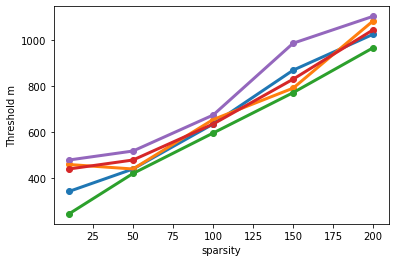

NameError: name 'saveData' is not defined

In [7]:
def experiment(x, s, m, repetitions = 3):
    accum = 0;
    for j in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        _, accuracy =  MNIST.reconstruct_BIP(A, q, x,
                                       lambda x : sparsity.HT_transform(x, s, sparsity.haar2d, sparsity.inverse_haar2d),
                                       learning_param = 0.001, iterations = 500);
        accum = accum + accuracy;
    return accum/repetitions;

def bisection(x, s, eps = 20):
    best = sparsity.best_error_transform(x, s, sparsity.haar2d, sparsity.inverse_haar2d);
    worst = experiment(x, s, 1);
    threshold = 0.5*(best + worst);
    
    _m_h = m_max;
    _m_l = m_min;
    
    while (_m_h - _m_l > eps):
        _m_m = int(0.5*(_m_h + _m_l));
        _m_m_value =  experiment(x, s, _m_m);
        if _m_m_value < threshold:
            _m_h = _m_m;
        else:
            _m_l = _m_m;
    
    return 0.5*(_m_h + _m_l);


    
data_haar = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    data_haar.append([]);
    for s in sspace:
        best = sparsity.best_error_transform(x, s, sparsity.haar2d, sparsity.inverse_haar2d);
        worst = experiment(x, s, 1);
        threshold_m = bisection(x, s);
        tup = (s, best, worst, threshold_m);
        data_haar[j].append(tup);

        clear_output(wait=True);
        print("latest s: " + str(s));
        plot_data(data_haar);

saveData(data_haar, "results_data/mnist_haar_complexity.dat");

In [8]:
utils.saveData(data_haar, "results_data/mnist_haar_complexity.dat");

# Generative

latest k: 200


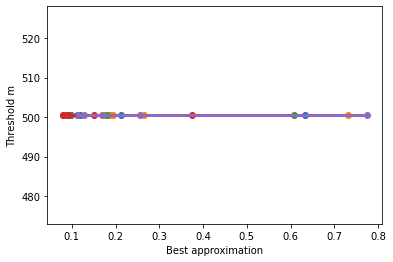

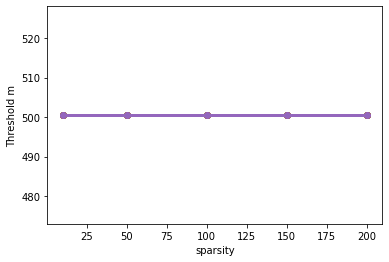

In [24]:
def experiment(x, m, network, repetitions = 3, random_restarts = 2):
    accum = 0;
    for j in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        projector =  lambda x : generative.project(x, network,  num_epochs = 100, learning_rate = 0.001);
        
        best = 10000000000;
        best_obj = 10000000000000;
        for i in range(random_restarts):
            y, accuracy = MNIST.reconstruct_BIP(A, q, x, projector, learning_param = 0.001, iterations = 100);
            inter = np.multiply(A.dot(utils.normalize(y)),q);
            inter = [min(z, 0) for z in inter];
            
            if linalg.norm(inter, ord=1) < best_obj:
                best_obj = linalg.norm(inter, ord=1);
                best = linalg.norm(utils.normalize(x) - utils.normalize(y));
                
        accum = accum + best;
    return accum/repetitions;

def bisection(x, network, eps = 15):
    best = linalg.norm(utils.normalize(x)-utils.normalize(generative.project(x, network, num_epochs = 200, learning_rate = 0.0001)));
    worst = experiment(x, 1, network);
    threshold = 0.5*(best + worst);
    print(str(best) + ", " + str(worst) + " --- " + str(threshold));
    _m_h = 1;
    _m_l = 1000;
    
    while (_m_h - _m_l > eps):
        _m_m = int(0.5*(_m_h + _m_l));
        _m_m_value =  experiment(x, _m_m, network);
        print(str(_m_m) + " : " +str(_m_m_value));
        if _m_m_value < threshold:
            _m_h = _m_m;
        else:
            _m_l = _m_m;
    
    return 0.5*(_m_h + _m_l);


#utils.reset_seeds();
#_networks = [generative.createNetwork(1, k)[1] for k in kspace];
#for i in range(len(kspace)):
#    generative.trainNetwork(_networks[i], train_loader, num_epochs = 4, learning_rate = 0.001);

data_gen = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    data_gen.append([]);
    for i in range(len(kspace)):
        k = kspace[i];
        best = linalg.norm(utils.normalize(x)-utils.normalize(generative.project(x, _networks[i], num_epochs = 200, learning_rate = 0.0001)));
        worst = experiment(x, 1,  _networks[i]);
        threshold_m = bisection(x, _networks[i]);
        tup = (k, best, worst, threshold_m);
        data_gen[j].append(tup);

        clear_output(wait=True);
        print("latest k: " + str(k));
        plot_data(data_gen);

utils.saveData(data_gen, "results_data/mnist_gen_complexity.dat");

# Plotting

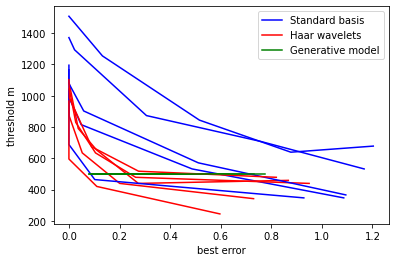

In [26]:
x_data1 = [];
y_data1 = [];
for subdata in data_sparsity:
    x_subdata = [];
    y_subdata = [];
    for (s, best, worst, threshold_m) in subdata:
        x_subdata.append(best);
        y_subdata.append(threshold_m);
    x_data1.append(x_subdata);
    y_data1.append(y_subdata);
    
    
x_data2 = [];
y_data2 = [];
for subdata in data_haar:
    x_subdata = [];
    y_subdata = [];
    for (s, best, worst, threshold_m) in subdata:
        x_subdata.append(best);
        y_subdata.append(threshold_m);
    x_data2.append(x_subdata);
    y_data2.append(y_subdata);
    
x_data3 = [];
y_data3 = [];
for subdata in data_gen:
    x_subdata = [];
    y_subdata = [];
    for (s, best, worst, threshold_m) in subdata:
        x_subdata.append(best);
        y_subdata.append(threshold_m);
    x_data3.append(x_subdata);
    y_data3.append(y_subdata);
    
for i in range(5):
    plt.plot(x_data1[i], y_data1[i], c='b');
    plt.plot(x_data2[i], y_data2[i], c='r');
    plt.plot(x_data3[i], y_data3[i], c='g');
    
    
    
plt.legend(["Standard basis", "Haar wavelets", "Generative model"]);
plt.xlabel("best error");
plt.ylabel("threshold m");

plt.savefig("results_images\complexity_tradeoff_best.png",dpi=200);

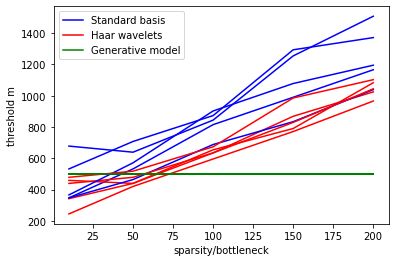

In [29]:
x_data1 = [];
y_data1 = [];
for subdata in data_sparsity:
    x_subdata = [];
    y_subdata = [];
    for (s, best, worst, threshold_m) in subdata:
        x_subdata.append(s);
        y_subdata.append(threshold_m);
    x_data1.append(x_subdata);
    y_data1.append(y_subdata);
    
    
x_data2 = [];
y_data2 = [];
for subdata in data_haar:
    x_subdata = [];
    y_subdata = [];
    for (s, best, worst, threshold_m) in subdata:
        x_subdata.append(s);
        y_subdata.append(threshold_m);
    x_data2.append(x_subdata);
    y_data2.append(y_subdata);
    
x_data3 = [];
y_data3 = [];
for subdata in data_gen:
    x_subdata = [];
    y_subdata = [];
    for (k, best, worst, threshold_m) in subdata:
        x_subdata.append(k);
        y_subdata.append(threshold_m);
    x_data3.append(x_subdata);
    y_data3.append(y_subdata);
    
for i in range(5):
    plt.plot(x_data1[i], y_data1[i], c='b');
    plt.plot(x_data2[i], y_data2[i], c='r');
    plt.plot(x_data3[i], y_data3[i], c='g');
    
    
    
plt.legend(["Standard basis", "Haar wavelets", "Generative model"]);
plt.xlabel("sparsity/bottleneck");
plt.ylabel("threshold m");

plt.savefig("results_images\complexity_tradeoff_sparsity_bottleneck.png",dpi=200);

In [28]:
data_sparsity = utils.loadData("results_data/mnist_standard_basis_complexity.dat");
data_haar = utils.loadData("results_data/mnist_haar_complexity.dat");
data_gen = utils.loadData("results_data/mnist_gen_complexity.dat");